In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import xgboost as xgb
# import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import get_absolute_path, load_data, save_csv, data_prep_X, gen_col_name, data_pre_Y
from utils.constants import *

# from src.data_input import *

In [3]:
# Import data

df_train = pd.read_csv(get_absolute_path('X_train.csv', 'data'))
y_train = pd.read_csv(get_absolute_path('y_train.csv', 'data'))
df_test = pd.read_csv(get_absolute_path('X_test.csv', 'data'))
y_test = pd.read_csv(get_absolute_path('y_test.csv', 'data'))



In [4]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,0.001131,0.884615,0.001120,0.001113,0.677632,0.841463,0.765152,0.787402,0.293750,0.298077,0.276163
1,0.001170,0.871795,0.001159,0.001152,0.703947,0.829268,0.772727,0.795276,0.293750,0.301282,0.276163
2,0.001326,0.884615,0.001198,0.001250,0.677632,0.853659,0.750000,0.755906,0.300000,0.298077,0.287791
3,0.014094,0.858974,0.001238,0.003926,0.697368,0.829268,0.772727,0.771654,0.296875,0.294872,0.279070
4,0.088109,0.858974,0.010766,0.029297,0.684211,0.853659,0.765152,0.755906,0.296875,0.291667,0.281977


In [5]:
df_test.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,0.002300,0.910256,0.001984,0.002051,0.578947,0.865854,0.651515,0.661417,0.571875,0.573718,0.543605
1,0.243665,0.923077,0.002534,0.110547,0.572368,0.902439,0.575758,0.503937,0.553125,0.541667,0.537791
2,0.208577,0.884615,0.007957,0.095508,0.565789,0.890244,0.583333,0.535433,0.556250,0.544872,0.552326
3,0.391813,0.935897,0.061100,0.228516,0.519737,0.926829,0.530303,0.519685,0.537500,0.528846,0.526163
4,0.497076,0.961538,0.243615,0.353516,0.486842,0.926829,0.530303,0.519685,0.531250,0.528846,0.514535


In [6]:
y_train.head()

,measurement
0,0.648148
1,0.648148
2,0.648148
3,0.638889
4,0.648148


# Data

To make valid comparison across different methods, we split the original `df_train` into new train and validation data sets.

In [7]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=42)

# XGBoost

Adding hyperparameter tuning.

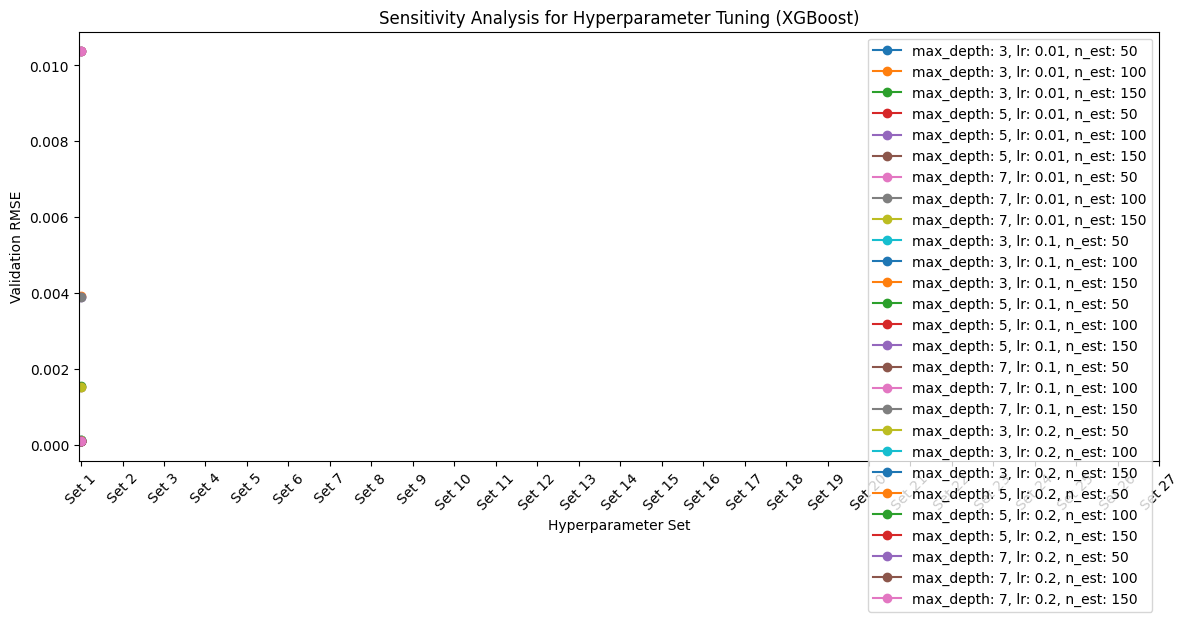

XGBoost RMSE: 0.008129699277925504


In [9]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Converting the data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV with the XGBoost regressor and parameter grid
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5)

# Perform the grid search on the data
grid_search.fit(X_train, y_train)

# Get the results of the grid search
results = grid_search.cv_results_
params_list = results['params']
rmse_list = [-x for x in results['mean_test_score']]  # Convert negative MSE to RMSE

# Visualization: Sensitivity Analysis
plt.figure(figsize=(12, 6))

for i, params in enumerate(params_list):
    label = f"max_depth: {params['max_depth']}, lr: {params['learning_rate']}, n_est: {params['n_estimators']}"
    plt.plot(rmse_list[i], marker='o', label=label)

plt.title("Sensitivity Analysis for Hyperparameter Tuning (XGBoost)")
plt.xlabel("Hyperparameter Set")
plt.ylabel("Validation RMSE")
plt.xticks(ticks=range(len(params_list)), labels=[f"Set {i+1}" for i in range(len(params_list))], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the XGBoost model with the best parameters
best_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_model_xgb.fit(X_train, y_train)

# Making predictions with the best model
y_pred_xgb = best_model_xgb.predict(X_val)

# Calculating RMSE
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
print("XGBoost RMSE:", rmse_xgb)


In [15]:
best_model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
rmse_list

[0.010373701960461282,
 0.003918325351661032,
 0.0015446604184220368,
 0.010366624792110769,
 0.0039032466457871893,
 0.0015253482105134807,
 0.010367625113150375,
 0.003902764711279838,
 0.0015187194201661141,
 0.0001310812490629278,
 0.00011637205175107611,
 0.00011175769340683113,
 0.00010951532123963271,
 0.00010093289636816225,
 9.815331243125674e-05,
 9.916430801066129e-05,
 9.326570985843131e-05,
 9.16546826334392e-05,
 0.00011633449307359058,
 0.00010997354745078949,
 0.00010605744030404417,
 0.00010309618889921949,
 0.00010026695732758421,
 9.893897494148333e-05,
 9.568174760627366e-05,
 9.357121059221363e-05,
 9.332555335593805e-05]

# Random Forest

/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/pyth

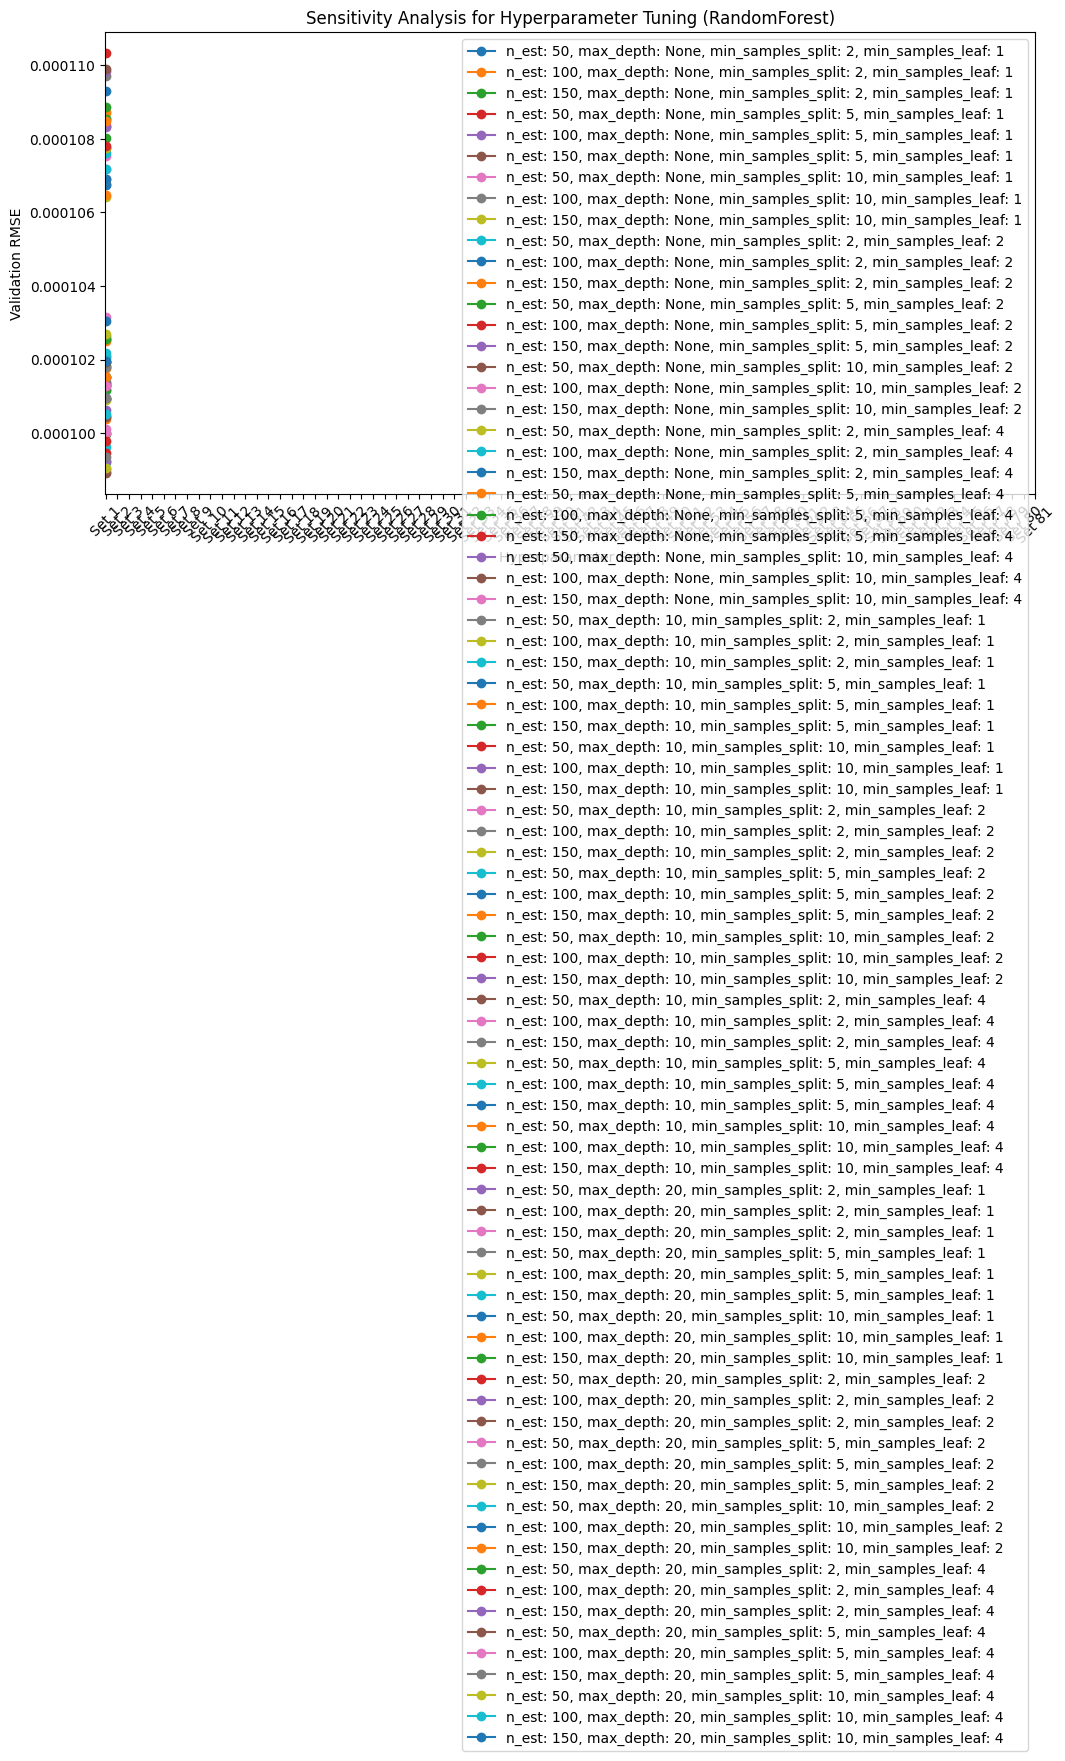

/var/folders/sq/7q5rg1dn4c3_2sgl1c3xkrgh0000gn/T/ipykernel_16709/3501719736.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model_rf.fit(X_train, y_train)


RandomForest RMSE: 0.00852520450338123


In [12]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForest regressor
rf_reg = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the RandomForest regressor and parameter grid
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5)

# Perform the grid search on the data
grid_search.fit(X_train, y_train)

# Get the results of the grid search
results = grid_search.cv_results_
params_list = results['params']
rmse_list = [-x for x in results['mean_test_score']]  # Convert negative MSE to RMSE

# Visualization: Sensitivity Analysis
plt.figure(figsize=(12, 6))

for i, params in enumerate(params_list):
    label = f"n_est: {params['n_estimators']}, max_depth: {params['max_depth']}, min_samples_split: {params['min_samples_split']}, min_samples_leaf: {params['min_samples_leaf']}"
    plt.plot(rmse_list[i], marker='o', label=label)

plt.title("Sensitivity Analysis for Hyperparameter Tuning (RandomForest)")
plt.xlabel("Hyperparameter Set")
plt.ylabel("Validation RMSE")
plt.xticks(ticks=range(len(params_list)), labels=[f"Set {i+1}" for i in range(len(params_list))], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the RandomForest model with the best parameters
best_model_rf = RandomForestRegressor(random_state=42, **best_params)
best_model_rf.fit(X_train, y_train)

# Making predictions with the best model
y_pred_rf = best_model_rf.predict(X_val)

# Calculating RMSE
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
print("RandomForest RMSE:", rmse_rf)


In [14]:
best_model_rf

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=150,
                      random_state=42)

# LightBGM

In [13]:


# # Creating a LightGBM dataset
# lgb_train = lgb.Dataset(X_train, label=y_train)
# lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# # Defining LightGBM parameters
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'num_leaves': 31,
#     'n_estimators': 100
# }

# # Training the LightGBM model
# model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=10)

# # Making predictions
# y_pred_lgb = model_lgb.predict(X_val)

# # Calculating RMSE
# rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
# print("LightGBM RMSE:", rmse_lgb)
